*Importing required libraries*

In [80]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn transformers datasets torch evaluate rouge_score nltk sentencepiece wordcloud 'accelerate>=0.26.0'

In [2]:
!{sys.executable} -m pip show transformers
!{sys.executable} -m pip show accelerate
!{sys.executable} -m pip show sentencepiece

Name: transformers
Version: 4.45.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /opt/miniconda3/envs/tf-metal/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Name: accelerate
Version: 1.0.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /opt/miniconda3/envs/tf-metal/lib/python3.10/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
Name: sentencepiece
Version: 0.2.0
Summary: SentencePiece python 

In [71]:
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from evaluate import load as load_metric
import accelerate
import torch
import numpy as np
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import pandas as pd


# Project Topic & Data

I selected [cnn_dailymail](https://huggingface.co/datasets/ccdv/cnn_dailymail) as my data source. This contains articles and summaries from CNN and Daily Mail.

The goal of my project is to train a model that can **summarize content from articles**. 
* Concise and relevant summaries are important for distilling large volumes of information. For example, providing a summary on a newsfeed. 

This is a **sequence-to-sequence task** that generates a modified version of a source text. This uses **supervised learning** with input sequences (article content) and target sequences (summary). The goal is for the model to learn by minimizing the difference between the generated output and the true target sequence.

In [4]:
# loading the dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

# EDA

My procedure is as follows:
1. **Data Exploration**
    * I will look at the quantity of data in my source as well as the lengths of the articles and summaries (also referred to as highlights)
    * The features in this project are the words in the articles and their relationships.
2. **Data Quality**
    * I will inspect the quality of my data both by sampling it and looking for null values.
3. **Data Preprocessing and Transformation**
    * **Tokenization**
        * I need to tokenize my data for model training.
    * **Cleaning**
        * I will remove unnecessary characters to streamline the data and improve training efficiency.
    * **Sequence Length**
        * I will employ processes to ensure that sequences are consistent length, which is important for processing efficiency.

In [5]:
# take a look at the dataframe structure
dataset['train'].to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   article     287113 non-null  object
 1   highlights  287113 non-null  object
 2   id          287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB


**The data source has 287,113 articles!** However, due to resource constraints (compute and time), I will be working with a small subset of the data source.

In [6]:
train_subset_size = 1000
val_subset_size = 200

train_data = dataset['train'].shuffle(seed=42).select(range(train_subset_size))
val_data = dataset['validation'].shuffle(seed=42).select(range(val_subset_size))

*Let's take a look at a sample of data.*

In [7]:
train_data_df = train_data.to_pandas()
train_data_df.head()

,article,highlights,id
0,"By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 ...",John and .\nAudrey Cook were discovered alongs...,08cf276c9eadb638e0c7fdc83ce0229c8af5d09b
1,UNITED NATIONS (CNN) -- A rare meeting of U.N....,NEW: Libya can serve as example of cooperation...,a0965f34cb08bd7db5845f8285dc8a9512d3e590
2,Cover-up: Former Archbishop Lord Hope allowed ...,Very Reverend Robert Waddington sexually abuse...,e960738caa9d39737f459e39923b20160f73f258
3,"By . Kristie Lau . PUBLISHED: . 10:48 EST, 14 ...",Monday night's episode showed Buddy Valastro t...,9befc7ac904202d6e018093c2923f04479d6af05
4,'The lamps are going out all over Europe. We s...,People asked to turn out lights for hour betwe...,dc3c9f319ca17b33ad87c71049a8589e474ba769


In [8]:
# here I check for null values in the data
train_data_df.isnull().sum()

article       0
highlights    0
id            0
dtype: int64

In [9]:
# here we'll see we've narrowed the data down to 1250
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     1000 non-null   object
 1   highlights  1000 non-null   object
 2   id          1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


**Below, I'll look at the 50 most common words present in the articles, ranked most common to least.**

In [82]:
all_words = list(itertools.chain(*[article.split() for article in train_data_df['article']]))
word_counts = Counter(all_words)
print(word_counts.most_common(50))

[('the', 34402), ('to', 18597), ('of', 16242), ('a', 15754), ('and', 15742), ('in', 13404), ('.', 11098), ('was', 6545), ('that', 6265), ('for', 6062), ('on', 5849), ('is', 5630), ('with', 4823), ('The', 4741), ('his', 4089), ('he', 3957), ('as', 3814), ('at', 3727), ('from', 3257), ('have', 3241), ('has', 3056), ('by', 3055), ('be', 2983), ('are', 2872), ('it', 2862), ('said', 2688), ('her', 2618), ('an', 2468), ('not', 2270), ('who', 2269), ('they', 2243), ('had', 2159), ('their', 2123), ('I', 2073), ('were', 2061), ('been', 2032), ('she', 2000), ('after', 1941), ('but', 1923), ('will', 1780), ('this', 1737), ('which', 1584), ('about', 1414), ('-', 1397), ('or', 1355), ('when', 1309), ('one', 1281), ('would', 1268), ('up', 1265), ('also', 1255)]


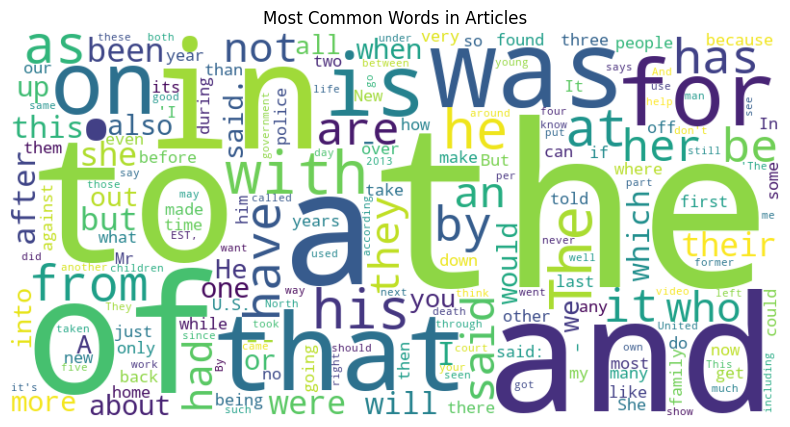

In [83]:
from wordcloud import WordCloud

word_freq = dict(word_counts)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Articles")
plt.show()

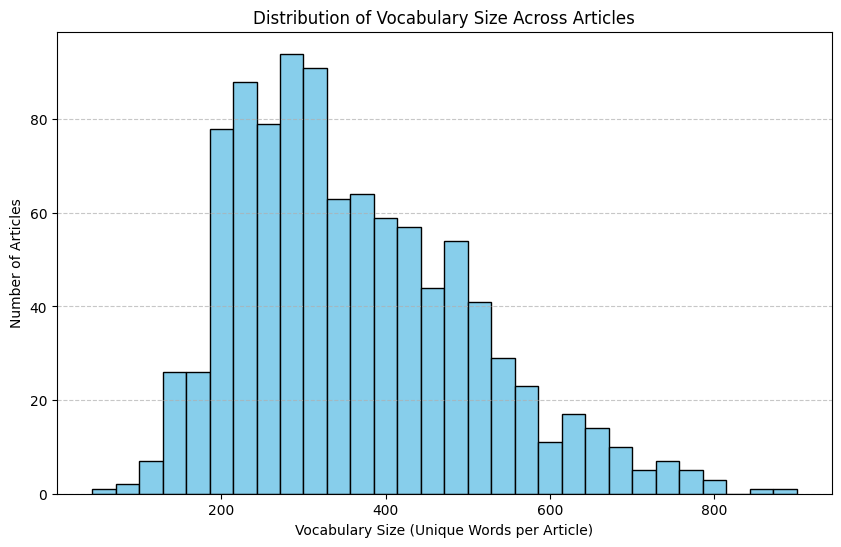

In [84]:
train_data_df['vocab_size'] = train_data_df['article'].apply(lambda x: len(set(x.split())))

plt.figure(figsize=(10, 6))
plt.hist(train_data_df['vocab_size'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Vocabulary Size Across Articles")
plt.xlabel("Vocabulary Size (Unique Words per Article)")
plt.ylabel("Number of Articles")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**I will now clean the text to improve the ability for the model to interpret the input sequences.**

In [8]:
import re

def clean_text(text):
    text = text.lower()
    text = " ".join(text.split())
    text = re.sub(r'[^\w\s.,]', '', text)
    return text

**I want to take a look at the lengths of the articles and highlights.** 
* This is important to understand when choosing max input and target lengths for training data. I'll set the maxes a little above the means.

In [9]:
sample_tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-6-6')

train_data_df['article_length'] = train_data_df['article'].apply(lambda x: len(sample_tokenizer.tokenize(x)))
train_data_df['highlight_length'] = train_data_df['highlights'].apply(lambda x: len(sample_tokenizer.tokenize(x)))

print(train_data_df[['article_length', 'highlight_length']].describe())

       article_length  highlight_length
count     1000.000000       1000.000000
mean       876.575000         65.425000
std        411.610128         25.804811
min         65.000000         10.000000
25%        563.750000         49.000000
50%        798.000000         62.000000
75%       1111.000000         76.000000
max       2285.000000        279.000000


**Now, I will define functions to preprocess the articles and summaries.**

In [10]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

max_input_length = 1000
max_target_length = 80

bart_tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-6-6')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

# clean the text and break sentences down into manageable units (tokenize)
def preprocess_function_bart(batch):
    batch['article'] = [clean_text(article) for article in batch['article']]
    batch['highlights'] = [clean_text(highlights) for highlights in batch['highlights']]
    
    inputs = bart_tokenizer(batch['article'], max_length=max_input_length, truncation=True, padding="max_length", return_tensors="pt")
    outputs = bart_tokenizer(batch['highlights'], max_length=max_target_length, truncation=True, padding="max_length", return_tensors="pt")
    batch['input_ids'] = inputs['input_ids']
    batch['attention_mask'] = inputs['attention_mask']
    inputs['labels'] = outputs['input_ids']
    return inputs

def preprocess_function_t5(batch):
    batch['article'] = [clean_text(article) for article in batch['article']]
    batch['highlights'] = [clean_text(highlights) for highlights in batch['highlights']]
    
    input_text_data = ["summarize: " + doc for doc in batch["article"]]
    inputs = t5_tokenizer(input_text_data, max_length=max_input_length, truncation=True, padding="max_length")
    outputs = t5_tokenizer(batch['highlights'], max_length=max_target_length, truncation=True, padding="max_length")
    batch['input_ids'] = inputs['input_ids']
    batch['attention_mask'] = inputs['attention_mask']
    inputs['labels'] = outputs['input_ids']
    return inputs

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# Models

1. **Model selection and comparison:** I will compare the following transformer based architectures:
    * **DistilBART:** Optimized for efficiency with a smaller set of parameters
    * **T5:** Text-to-text transformer. Effective for various text-generation tasks
2. **Training**
    * For each model, I will train and evaluate loss, metrics, and samples to determine the next which to move forward with for hyperparameter tuning.
3. **Evaluation Metric:**  
    * I will use **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) as my metric to optimize through training. This metric looks at the overlap of words between two sets of text (generated and target in this case).

*Below, I define a function I will use in training for evaluating the metrics*

In [11]:
rouge = load_metric("rouge")
def compute_metrics(pred, tokenizer=bart_tokenizer):
    predictions, labels = pred
    # check datatypes throughtout the process
    print("Type of predictions:", type(predictions))
    print("Type of labels:", type(labels))

    # transform data if necessary
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    if isinstance(predictions, torch.Tensor):
        predictions = torch.argmax(predictions, dim=-1).tolist()
    elif isinstance(predictions, np.ndarray):
        predictions = np.argmax(predictions, axis=-1).tolist()

    
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    # process the the labels and predictions into sets the tokenizer can interpret
    labels = [[token for token in label if token != tokenizer.pad_token_id] for label in labels]
    predictions = [[token for token in pred if token != tokenizer.pad_token_id] for pred in predictions]

    # decode the data
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    #compute and evaluate result
    result = rouge.compute(predictions=decoded_predictions, references=decoded_labels, use_stemmer=True)
    if isinstance(result["rouge1"], dict):
        rouge1 = result["rouge1"].get("fmeasure", 0.0)
        rouge2 = result["rouge2"].get("fmeasure", 0.0)
        rougeL = result["rougeL"].get("fmeasure", 0.0)
    else:
        rouge1 = result["rouge1"]
        rouge2 = result["rouge2"]
        rougeL = result["rougeL"]

    return {
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rougeL,
    }

def compute_metrics_with_bart_tokenizer(eval_pred):
    return compute_metrics(eval_pred, tokenizer=bart_tokenizer)

def compute_metrics_with_t5_tokenizer(eval_pred):
    return compute_metrics(eval_pred, tokenizer=t5_tokenizer)

## Comparing architectures

In [52]:
# start with a small dataset to get an idea of how both architectures handle training
comp_train_subset_size = 150
comp_val_subset_size = 30
comparison_train_data = train_data.select(range(comp_train_subset_size))
comparison_val_data = val_data.select(range(comp_val_subset_size))


## Architecture: DistilBART

In [58]:
bart_model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-6-6')


In [59]:
# preprocess specific for DistilBART
bart_train_data = comparison_train_data.map(preprocess_function_bart, batched=True)
bart_val_data = comparison_val_data.map(preprocess_function_bart, batched=True)

training_args_bart = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    eval_steps=2000,
    learning_rate=1e-04,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=2000,
    save_total_limit=3,
    use_cpu=True,
    fp16=True
    )

In [60]:
# define the trainer I'll use
trainer_bart = Trainer(
    model=bart_model,
    args=training_args_bart,
    train_dataset=bart_train_data,
    eval_dataset=bart_val_data,
    tokenizer=bart_tokenizer,
    compute_metrics=compute_metrics_with_bart_tokenizer,
)

In [61]:
trainer_bart.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,No log,1.783595,0.578662,0.310932,0.523122
2,1.990200,1.916158,0.571656,0.306969,0.520521
3,0.659000,2.077934,0.573390,0.313426,0.519826
4,0.264500,2.335343,0.565036,0.304304,0.510211


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


/opt/miniconda3/envs/tf-metal/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


TrainOutput(global_step=152, training_loss=0.962514332250545, metrics={'train_runtime': 1048.2319, 'train_samples_per_second': 0.572, 'train_steps_per_second': 0.145, 'total_flos': 634901299200000.0, 'train_loss': 0.962514332250545, 'epoch': 4.0})

In [62]:
results_bart = trainer_bart.evaluate()
print(results_bart)

Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
{'eval_loss': 2.335343360900879, 'eval_rouge1': 0.5650360178047953, 'eval_rouge2': 0.3043037635443412, 'eval_rougeL': 0.510211457123572, 'eval_runtime': 14.6249, 'eval_samples_per_second': 2.051, 'eval_steps_per_second': 2.051, 'epoch': 4.0}


In [63]:
# example text generated by ChatGPT to test summarization
# Sample text from https://www.autoevolution.com/news/the-mclaren-w1-is-said-to-be-a-technological-masterpiece-nobody-cares-240958.html
basic_text = """
Sure, the latest Ultimate Series model is powerful: its hybrid powertrain with a 4-liter V8 delivers 1,258 hp (1,275 PS). In fact, it is the most powerful McLaren ever made. It is also quick, reaching 100 kph (62 mph) from a standstill in 2.7 seconds. Its top speed is 350 kph (217 mph). You'll have the impression you have already seen these technical specifications somewhere else, and you'll be very right. Although the W1 is limited to 399 units, there's nothing extraordinary about it apart from its base price (£2 million).

Just go check Facebook, Instagram, and any social media you may prefer. Nobody is talking about the W1. The exceptions are the websites and magazines trying to promote their articles about this hypercar, hoping that the posts about it will make audience numbers as high as its price tag. They have tried it before with the Bugatti Tourbillon, the Venom F5, the Rimac Nevera, and a long list of other products. Hypercars are not moving the needle as much as they used to.

McLaren couldn't care less. It has already sold all units to all the guys who want to look good when they park in front of the country club, making a hell of an effort to leave the cabin without looking unfit or too old. Even if a small percentage of these 399 cars is taken to a race track, I doubt it will make them any more attractive. Unless they are the only hypercars around, there's a good chance someone will beat their time. Ironically, that will depend more on the driver than on the machine. What a difference from what we had when the Ferrari F40 and the McLaren F1 were first presented...

It may be the case that the McLaren F1 became such a special machine because no other car could hit the same speeds, but the main picture I selected for this article shows it is more than that. Look how small it looks compared to the P1 and the W1. Despite that, it is still the most capable of the three. McLaren made these successors bigger, probably roomier and more comfortable, a lot heavier, and certainly more powerful, but it did not make them better (hyper)cars than the F1 was (and still is). Why? I have no idea, but I've got some clues.
"""

In [64]:

# ensuring my model to CPU to prevent resource errors
device = torch.device("cpu")
bart_model.to(device)

# tokenize
inputs_b = bart_tokenizer([basic_text], max_length=max_input_length, return_tensors="pt", truncation=True).to(device)

# use my trained model to generate a summary
summary_ids_b = bart_model.generate(inputs_b["input_ids"], max_length=128, min_length=10, length_penalty=2.0, num_beams=2, early_stopping=False)

#decode to readable text
summary_b = bart_tokenizer.decode(summary_ids_b[0], skip_special_tokens=True)

print("Summary:", summary_b)

Summary: the McLaren F1 is the latest Ultimate Series model to go under the hammer . despite its limited number of 399 models, there is nothing extraordinary about it apart from its base price of £2 million . McLarens latest hypercar is the most powerful McLarens ever made . its hybrid powertrain with a 4-liter V8 delivers 1,258 hp (1,275 PS) its top speed is 350 kph (217 mph)


## Architecture: T5

In [65]:
t5_train_data = comparison_train_data.map(preprocess_function_t5, batched=True)
t5_val_data = comparison_val_data.map(preprocess_function_t5, batched=True)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [66]:
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

t5_training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    eval_steps=2000,
    learning_rate=1e-04,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=2000,
    save_total_limit=3,
    use_cpu=True,
    fp16=True
)

t5_trainer = Trainer(
    model=t5_model,
    args=t5_training_args,
    train_dataset=t5_train_data,
    eval_dataset=t5_val_data,
    tokenizer=t5_tokenizer,
    compute_metrics=compute_metrics_with_t5_tokenizer,
    
)

t5_trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,No log,1.658218,0.582946,0.321436,0.540169
2,2.363400,1.601322,0.589601,0.327122,0.548879
3,1.577700,1.593500,0.588345,0.328992,0.549603
4,1.471900,1.591317,0.586932,0.328172,0.548693


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


TrainOutput(global_step=152, training_loss=1.8009548877414905, metrics={'train_runtime': 651.0693, 'train_samples_per_second': 0.922, 'train_steps_per_second': 0.233, 'total_flos': 158603673600000.0, 'train_loss': 1.8009548877414905, 'epoch': 4.0})

In [67]:
results = t5_trainer.evaluate()
print(results)

Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
{'eval_loss': 1.5913172960281372, 'eval_rouge1': 0.5869318028541919, 'eval_rouge2': 0.3281718195133029, 'eval_rougeL': 0.5486934234492445, 'eval_runtime': 6.626, 'eval_samples_per_second': 4.528, 'eval_steps_per_second': 4.528, 'epoch': 4.0}


In [68]:
def preprocess_text(text):
    return "summarize: " + text

# ensuring my model to CPU to prevent resource errors
device = torch.device("cpu")
t5_model.to(device)

# prepend "summarize: " for t5
input_text = preprocess_text(basic_text)

# tokenize
inputs = t5_tokenizer(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)

# use my trained model to generate a summary
summary_ids = t5_model.generate(
    inputs["input_ids"],
    max_length=150,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True
)

#decode to readable text
summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)

Generated Summary: the latest Ultimate Series model is the most powerful McLaren ever made. its hybrid powertrain with a 4-liter V8 delivers 1,258 hp (1,275 PS) it is also quick, reaching 100 kph (62 mph) in 2.7 seconds, and its top speed is 350.


**Comparing with the untrained model, we can see the summary has improved.**

In [69]:
untrained_model = T5ForConditionalGeneration.from_pretrained("t5-small")
summary_ids_u = untrained_model.generate(
    inputs["input_ids"],
    max_length=150,
    num_beams=4,
    early_stopping=True
)

summary_u = t5_tokenizer.decode(summary_ids_u[0], skip_special_tokens=True)
print("Generated Summary:", summary_u)

Generated Summary: the latest Ultimate Series model is the most powerful ever made. it is also quick, reaching 100 kph (62 mph) from a standstill in 2.7 seconds. there's nothing extraordinary about it apart from its base price (£2 million)


## Hyperparameter Tuning

I will proceed with **T5** for my hyperparameter tuning. Due to compute and time restraints, I am starting my hyperparameter search with a very small subset.

In [60]:
import itertools
from datetime import datetime

In [61]:
# using a much smaller set of articles to get an understanding of the best params for efficiency sake.
hp_train_subset_size = 50
hp_val_subset_size = 10

hp_train_data = train_data.select(range(hp_train_subset_size))
hp_val_data = val_data.select(range(hp_val_subset_size))

# preprocess for t5
hp_train_data = hp_train_data.map(preprocess_function_t5, batched=True)
hp_val_data = hp_val_data.map(preprocess_function_t5, batched=True)

# grid of params to adjust
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "weight_decay": [0.01, 0.1],
    "num_epochs": [2,3]
}

# combine those params
param_combinations = list(itertools.product(
    param_grid["learning_rate"],
    param_grid["weight_decay"],
    param_grid["num_epochs"]
))

# store the best score and params
best_score = 0
best_params = {}

for learning_rate, weight_decay, num_epochs in param_combinations:
    #init a fresh model
    t5_model_hp = T5ForConditionalGeneration.from_pretrained("t5-small")
    
    print(datetime.now(), learning_rate, weight_decay, num_epochs)

    # pull the params into training args
    training_args_hp = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=1,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        logging_dir="./logs",
        logging_steps=10,
        save_steps=500,
        save_total_limit=3,
        use_cpu=True
    )

    trainer_hp = Trainer(
        model=t5_model_hp,
        args=training_args_hp,
        train_dataset=hp_train_data,
        eval_dataset=hp_val_data,
        tokenizer=t5_tokenizer,        
        compute_metrics=compute_metrics_with_t5_tokenizer,
    )
    trainer_hp.train()

    # evaluate, compare, nad store the performance
    eval_results = trainer_hp.evaluate()
    rouge1_score = eval_results.get("eval_rouge1", 0)
    print(rouge1_score)
    if rouge1_score > best_score:
        best_score = rouge1_score
        best_params = {"learning_rate": learning_rate, "weight_decay": weight_decay, "num_epochs": num_epochs}
        print(f'**NEW BEST**: {best_params} @ {best_score}')
    
    print(f'Best params so far: {best_params} @ {best_score}')


2024-10-11 13:20:34.604741 1e-05 0.01 2


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.618000,4.839272,0.532576,0.276521,0.497671
2,5.028000,4.760901,0.533289,0.276814,0.498152


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5332893481245184
**NEW BEST**: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:22:33.218707 1e-05 0.01 3


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.615100,4.817076,0.532576,0.276521,0.497671
2,4.995400,4.667965,0.533289,0.276814,0.498152
3,4.431700,4.616174,0.533289,0.276814,0.498152


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5332893481245184
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:25:13.387770 1e-05 0.1 2


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.618000,4.839231,0.532576,0.276521,0.497671
2,5.028000,4.760848,0.533289,0.276814,0.498152


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5332893481245184
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:27:04.979288 1e-05 0.1 3


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.615100,4.817029,0.532576,0.276521,0.497671
2,4.995400,4.667886,0.533289,0.276814,0.498152
3,4.431700,4.616088,0.533289,0.276814,0.498152


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5332893481245184
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:29:56.462988 2e-05 0.01 2


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.543600,4.614007,0.531014,0.276970,0.495888
2,4.771400,4.457767,0.531818,0.277045,0.496623


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5318183225909958
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:31:57.378350 2e-05 0.01 3


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.537700,4.569559,0.531818,0.277045,0.496623
2,4.706700,4.279298,0.531014,0.276970,0.495888
3,4.102800,4.180226,0.532659,0.277848,0.497118


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5326592231706297
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:34:49.172769 2e-05 0.1 2


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.543500,4.613917,0.531014,0.276970,0.495888
2,4.771300,4.457591,0.531818,0.277045,0.496623


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5318183225909958
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:36:38.802080 2e-05 0.1 3


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.537600,4.569458,0.531818,0.277045,0.496623
2,4.706600,4.279609,0.531014,0.276970,0.495888
3,4.103000,4.180730,0.532659,0.277848,0.497118


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5326592231706297
Best params so far: {'learning_rate': 1e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5332893481245184
2024-10-11 13:39:29.321708 3e-05 0.01 2


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.469100,4.392386,0.532090,0.277385,0.496693
2,4.519000,4.159888,0.533504,0.277848,0.498257


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5335036819117241
**NEW BEST**: {'learning_rate': 3e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5335036819117241
Best params so far: {'learning_rate': 3e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5335036819117241
2024-10-11 13:41:30.174169 3e-05 0.01 3


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.460300,4.326791,0.532659,0.277848,0.497118
2,4.423600,3.891243,0.531307,0.272532,0.496303
3,3.777700,3.740533,0.531307,0.265910,0.492273


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.531306520133868
Best params so far: {'learning_rate': 3e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5335036819117241
2024-10-11 13:44:28.750035 3e-05 0.1 2


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.469100,4.392267,0.532090,0.277385,0.496693
2,4.518900,4.159740,0.533504,0.277848,0.498257


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.5335036819117241
Best params so far: {'learning_rate': 3e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5335036819117241
2024-10-11 13:46:29.107998 3e-05 0.1 3


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.460300,4.326647,0.532659,0.277848,0.497118
2,4.423400,3.891366,0.531307,0.272532,0.496303
3,3.777700,3.740046,0.531307,0.265910,0.492273


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
0.531306520133868
Best params so far: {'learning_rate': 3e-05, 'weight_decay': 0.01, 'num_epochs': 2} @ 0.5335036819117241


In [62]:
print(best_params)

{'learning_rate': 3e-05, 'weight_decay': 0.01, 'num_epochs': 2}


**Train using the best results.**

In [26]:
t5_best_train_data = train_data.map(preprocess_function_t5, batched=True)
t5_best_val_data = val_data.map(preprocess_function_t5, batched=True)

In [28]:
t5_model_best = T5ForConditionalGeneration.from_pretrained("t5-small")

training_args_best = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-05,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=3,
    use_cpu=True
    )

trainer_best = Trainer(
    model=t5_model_best,
    args=training_args_best,
    train_dataset=t5_best_train_data,
    eval_dataset=t5_best_val_data,
    tokenizer=t5_tokenizer,
    compute_metrics=compute_metrics_with_t5_tokenizer,
    )
trainer_best.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,1.725300,1.499864,0.603363,0.345000,0.564476
2,1.757400,1.487134,0.604117,0.346265,0.565347


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


TrainOutput(global_step=500, training_loss=1.9138371925354003, metrics={'train_runtime': 2265.6243, 'train_samples_per_second': 0.883, 'train_steps_per_second': 0.221, 'total_flos': 528678912000000.0, 'train_loss': 1.9138371925354003, 'epoch': 2.0})

In [29]:
eval_results_best = trainer_best.evaluate()

Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


In [31]:
# ensuring my model to CPU to prevent resource errors
device = torch.device("cpu")
t5_model_best.to(device)

inputs = t5_tokenizer(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
summary_ids = t5_model_best.generate(
    inputs["input_ids"],
    max_length=150,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True
)

summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)


Generated Summary: the latest Ultimate Series model is powerful: its hybrid powertrain delivers 1,258 hp (1,275 PS) it is also quick, reaching 100 kph (62 mph) from a standstill in 2.7 seconds. the W1 is limited to 399 units, but there's nothing extraordinary about it apart from its base price (£2 million)


In [33]:
# init model
et_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# smaller subsets for epoch analysis
et_train_subset_size = 100
et_val_subset_size = 20

# select the subsets
et_train_data = train_data.select(range(et_train_subset_size))
et_val_data = val_data.select(range(et_val_subset_size))

# preprocess specific for T5
et_train_data = et_train_data.map(preprocess_function_t5, batched=True)
et_val_data = et_val_data.map(preprocess_function_t5, batched=True)


et_training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-05,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=3,
    use_cpu=True
    )

et_trainer = Trainer(
    model=et_model,
    args=et_training_args,
    train_dataset=et_train_data,
    eval_dataset=et_val_data,
    tokenizer=t5_tokenizer,
    compute_metrics=compute_metrics_with_t5_tokenizer,
    )
et_trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,4.950900,2.984237,0.558542,0.288701,0.509206
2,2.757000,2.123438,0.567730,0.293926,0.518959
3,2.270200,1.681099,0.584645,0.302248,0.532432
4,1.830600,1.637340,0.578878,0.297476,0.525573
5,1.611000,1.637012,0.578772,0.297426,0.526266
6,1.834000,1.638922,0.579177,0.298361,0.527627
7,1.634600,1.636756,0.579459,0.297870,0.527477
8,1.751800,1.634604,0.582502,0.298594,0.531146
9,1.650100,1.633064,0.582093,0.298121,0.530918
10,1.655400,1.632668,0.581936,0.299936,0.531692


Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>
Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


TrainOutput(global_step=250, training_loss=2.230330772399902, metrics={'train_runtime': 1126.4275, 'train_samples_per_second': 0.888, 'train_steps_per_second': 0.222, 'total_flos': 264339456000000.0, 'train_loss': 2.230330772399902, 'epoch': 10.0})

In [34]:
eval_results_et = et_trainer.evaluate()

Type of predictions: <class 'tuple'>
Type of labels: <class 'numpy.ndarray'>


In [35]:
device = torch.device("cpu")
et_model.to(device)

inputs = t5_tokenizer(input_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
summary_ids = et_model.generate(
    inputs["input_ids"],
    max_length=150,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True
)

summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)


Generated Summary: the latest Ultimate Series model is powerful: its hybrid powertrain delivers 1,258 hp (1,275 PS) it is also quick, reaching 100 kph (62 mph) from a standstill in 2.7 seconds. there's nothing extraordinary about it apart from its base price (£2 million)


# Results & Analysis

### Model Performance

* DistilBART: This model was capable, but was outperformed by T5.
* T5: This demonstrated robustness and, with additional training, captured more critical features from the text.

DistilBART appears to train faster than T5 in this scenario, but based on validation loss, T5 appears more stable and has a lower loss. T5 outperforms DistilBART in all ROUGE metrics at each epoch, showing a better handling of sentence-level structure. The ROUGE scores for T5 remain consistant, showing it can generalize better.

  

### DistilBART
<div style="float: left;">
    
|Epoch|Training Loss|Validation Loss|Rouge1|Rouge2|Rougel|
|-|-|-|-|-|-|
|1|No log|1.783595|0.578662|0.310932|0.523122|
|2|1.990200|1.916158|0.571656|0.306969|0.520521|
|3|0.659000|2.077934|0.573390|0.313426|0.519826|
|4|0.264500|2.335343|0.565036|0.304304|0.510211|

</div>




### T5
<div style="float: left;">
    
|Epoch|Training Loss|Validation Loss|Rouge1|Rouge2|Rougel|
|-|-|-|-|-|-|
|1|No log|1.658218|0.582946|0.321436|0.540169|
|2|2.363400|1.601322|0.589601|0.327122|0.548879|
|3|1.577700|1.593500|0.588345|0.328992|0.549603|
|4|1.471900|1.591317|0.586932|0.328172|0.548693|
</div>




**Input text:** *Sure, the latest Ultimate Series model is powerful: its hybrid powertrain with a 4-liter V8 delivers 1,258 hp (1,275 PS). In fact, it is the most powerful McLaren ever made. It is also quick, reaching 100 kph (62 mph) from a standstill in 2.7 seconds. Its top speed is 350 kph (217 mph). You'll have the impression you have already seen these technical specifications somewhere else, and you'll be very right. Although the W1 is limited to 399 units, there's nothing extraordinary about it apart from its base price (£2 million). Just go check Facebook, Instagram, and any social media you may prefer. Nobody is talking about the W1. The exceptions are the websites and magazines trying to promote their articles about this hypercar, hoping that the posts about it will make audience numbers as high as its price tag. They have tried it before with the Bugatti Tourbillon, the Venom F5, the Rimac Nevera, and a long list of other products. Hypercars are not moving the needle as much as they used to. McLaren couldn't care less. It has already sold all units to all the guys who want to look good when they park in front of the country club, making a hell of an effort to leave the cabin without looking unfit or too old. Even if a small percentage of these 399 cars is taken to a race track, I doubt it will make them any more attractive. Unless they are the only hypercars around, there's a good chance someone will beat their time. Ironically, that will depend more on the driver than on the machine. What a difference from what we had when the Ferrari F40 and the McLaren F1 were first presented... It may be the case that the McLaren F1 became such a special machine because no other car could hit the same speeds, but the main picture I selected for this article shows it is more than that. Look how small it looks compared to the P1 and the W1. Despite that, it is still the most capable of the three. McLaren made these successors bigger, probably roomier and more comfortable, a lot heavier, and certainly more powerful, but it did not make them better (hyper)cars than the F1 was (and still is). Why? I have no idea, but I've got some clues.*


**DistilBART Summary:** the McLaren F1 is the latest Ultimate Series model to go under the hammer . despite its limited number of 399 models, there is nothing extraordinary about it apart from its base price of £2 million . McLarens latest hypercar is the most powerful McLarens ever made . its hybrid powertrain with a 4-liter V8 delivers 1,258 hp (1,275 PS) its top speed is 350 kph (217 mph)

**T5 Summary:** the latest Ultimate Series model is the most powerful McLaren ever made. its hybrid powertrain with a 4-liter V8 delivers 1,258 hp (1,275 PS) it is also quick, reaching 100 kph (62 mph) in 2.7 seconds, and its top speed is 350.

*Visualizing the performance above:*

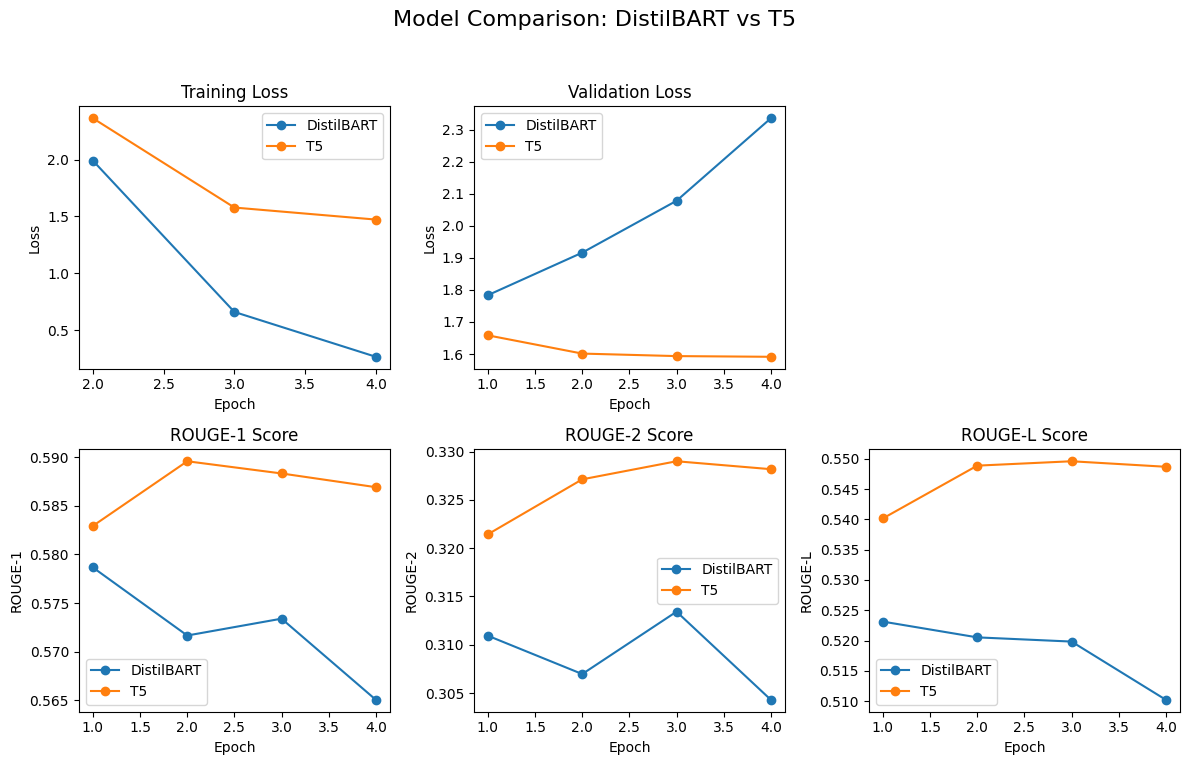

In [77]:
distilbart_data = {
    "Epoch": [1, 2, 3, 4],
    "Training Loss": [None, 1.990200, 0.659000, 0.264500],
    "Validation Loss": [1.783595, 1.916158, 2.077934, 2.335343],
    "ROUGE-1": [0.578662, 0.571656, 0.573390, 0.565036],
    "ROUGE-2": [0.310932, 0.306969, 0.313426, 0.304304],
    "ROUGE-L": [0.523122, 0.520521, 0.519826, 0.510211]
}

t5_data = {
    "Epoch": [1, 2, 3, 4],
    "Training Loss": [None, 2.363400, 1.577700, 1.471900],
    "Validation Loss": [1.658218, 1.601322, 1.593500, 1.591317],
    "ROUGE-1": [0.582946, 0.589601, 0.588345, 0.586932],
    "ROUGE-2": [0.321436, 0.327122, 0.328992, 0.328172],
    "ROUGE-L": [0.540169, 0.548879, 0.549603, 0.548693]
}

distilbart_df = pd.DataFrame(distilbart_data)
t5_df = pd.DataFrame(t5_data)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Model Comparison: DistilBART vs T5', fontsize=16)


axes[0, 0].plot(distilbart_df["Epoch"], distilbart_df["Training Loss"], label="DistilBART", marker="o")
axes[0, 0].plot(t5_df["Epoch"], t5_df["Training Loss"], label="T5", marker="o")
axes[0, 0].set_title("Training Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

axes[0, 1].plot(distilbart_df["Epoch"], distilbart_df["Validation Loss"], label="DistilBART", marker="o")
axes[0, 1].plot(t5_df["Epoch"], t5_df["Validation Loss"], label="T5", marker="o")
axes[0, 1].set_title("Validation Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

axes[0, 2].set_visible(False)

axes[1, 0].plot(distilbart_df["Epoch"], distilbart_df["ROUGE-1"], label="DistilBART", marker="o")
axes[1, 0].plot(t5_df["Epoch"], t5_df["ROUGE-1"], label="T5", marker="o")
axes[1, 0].set_title("ROUGE-1 Score")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("ROUGE-1")
axes[1, 0].legend()

axes[1, 1].plot(distilbart_df["Epoch"], distilbart_df["ROUGE-2"], label="DistilBART", marker="o")
axes[1, 1].plot(t5_df["Epoch"], t5_df["ROUGE-2"], label="T5", marker="o")
axes[1, 1].set_title("ROUGE-2 Score")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("ROUGE-2")
axes[1, 1].legend()

axes[1, 2].plot(distilbart_df["Epoch"], distilbart_df["ROUGE-L"], label="DistilBART", marker="o")
axes[1, 2].plot(t5_df["Epoch"], t5_df["ROUGE-L"], label="T5", marker="o")
axes[1, 2].set_title("ROUGE-L Score")
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel("ROUGE-L")
axes[1, 2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Hyperparameter Tuning

* I selected T5 to tune hyperparameters based on initial baseline testing. I conducted my search and adjusted learning rate, weight decay, and epoch count to find the best combination for effective (and time efficient) training. This resulted in **improvemed ROUGE scores**.
* I sought to understand T5's behavior and improve summariazation performance.

After tuning, I was able to improve my ROUGE scores and reduce validation loss.

<div style="float: left;">
    
||Training Loss|Validation|Loss	Rouge1|Rouge2|Rougel|
|-|-|-|-|-|-|
|Before Tuning|1.471900|1.591317|0.586932|0.328172|0.548693|
|After Tuning|1.757400|1.487134|0.604117|0.346265|0.565347|
</div>



**Summary after tuning:** the latest Ultimate Series model is powerful: its hybrid powertrain delivers 1,258 hp (1,275 PS) it is also quick, reaching 100 kph (62 mph) from a standstill in 2.7 seconds. the W1 is limited to 399 units, but there's nothing extraordinary about it apart from its base price (£2 million)

### Visualizing Scores by Epoch
I looked at metric values at each epoch using a smaller subset to get an idea of what happens to the scores. It looks like, with the smaller subset of training that we are working with, a smaller epoch count helps. This is also more time-efficient.

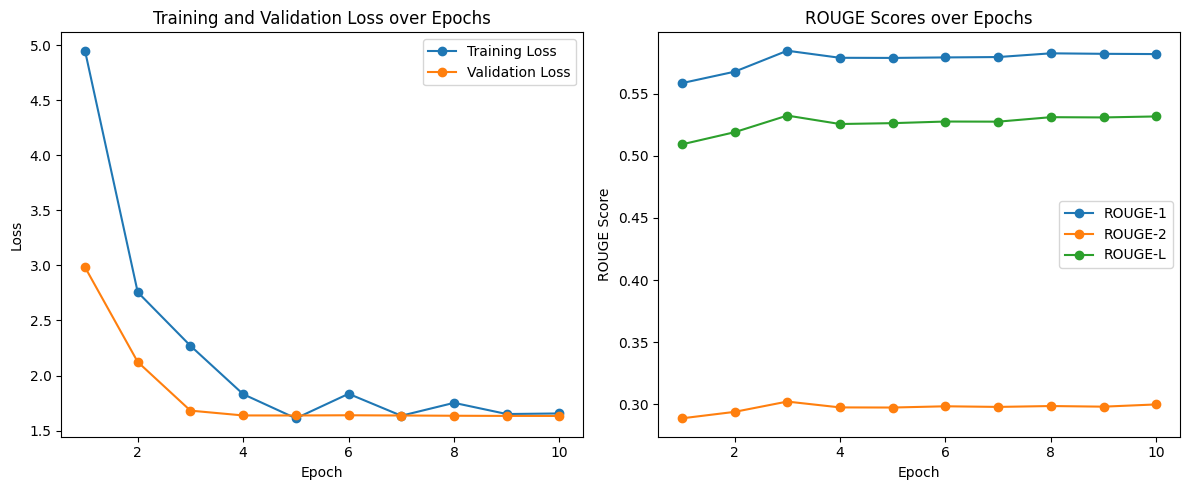

In [41]:
epochs = list(range(1, 11))
training_loss = [4.9509, 2.7570, 2.2702, 1.8306, 1.6110, 1.8340, 1.6346, 1.7518, 1.6501, 1.6554]
validation_loss = [2.9842, 2.1234, 1.6811, 1.6373, 1.6370, 1.6389, 1.6368, 1.6346, 1.6331, 1.6327]
rouge1 = [0.5585, 0.5677, 0.5846, 0.5789, 0.5788, 0.5792, 0.5795, 0.5825, 0.5821, 0.5819]
rouge2 = [0.2887, 0.2939, 0.3022, 0.2975, 0.2974, 0.2984, 0.2979, 0.2986, 0.2981, 0.2999]
rougel = [0.5092, 0.5190, 0.5324, 0.5256, 0.5263, 0.5276, 0.5275, 0.5311, 0.5309, 0.5317]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, rouge1, label="ROUGE-1", marker='o')
plt.plot(epochs, rouge2, label="ROUGE-2", marker='o')
plt.plot(epochs, rougel, label="ROUGE-L", marker='o')
plt.xlabel("Epoch")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Scores over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


# Discussion & Conclusion

### Key Takeaways

* Through my project, I found that T5 had the best performance and with a training it was able to pick up on key details.
* Hyperparameter tuning was helped with improving performance. Given the time, I wouild spend more effort on tuning.

### Difficulties
* My biggest struggle was time and resource constraints. The time it takes to train made it difficult to really fine tune the model.
* Additionally, I had to really work to understand why the sample outputs behaved the way they did -- for example, cutting off mid sentence.

### Future Improvements
* In the future, I would **improve** my project by increasing the size of my training dataset. I decided to use a small subset due to **time and resource constraints**, but I feel that the model could have done much better if it were training on a larger subset.